# OZNAL - Exploratívna analýza
Miroslav Čulík, Andrej Gáfrik

**TODOs:**
- ~~este raz prebehnuť a doplniť veci k single column analýze - hlavne preskumať outliers - vysoke ceny, rozlohy, počet spální, atď. - všetky outliery sú vypísané v časti [1.2.4 Opis vychýlených hodnôt](#Definovanie-%C3%BAlohy-objavovania-znalost%C3%AD)~~
- v časti [1.2.2](#P%C3%A1rov%C3%A1-anal%C3%BDza-atrib%C3%BAtov) doplniť párovú analýzu pri relevantných stlpcoch, vhodne vizualizovať
- v časti [1.3](#Definovanie-%C3%BAlohy-objavovania-znalost%C3%AD) popisat algoritmy, ktorymi to chceme pravdepodobne riesit - top 3 na regresiu
- v časti [1.4](#Predpokladan%C3%BD-scen%C3%A1r-rie%C5%A1enia-(probl%C3%A9my)) popísať scenár ako chceme ďalej postupovať

~~- odvodené atribúty - napr. *age domu*, príp. doba od poslednej rekonštrukcie (ak nebola, tak doba od postavenia) po dobu predaja~~
- napísať report z vybraných častí jupyter notebooku na 1-2 strany v LateX-u ---> šablóna ktorú máme použiť [overleaf link](https://www.overleaf.com/project/5e7101e344e1ac0001e3041b)
[link for download zip file](ftp://ftp.springernature.com/cs-proceeding/llncs/llncs2e.zip) 

## Opis problému, motivácia

V našom projekte by sme chceli sa chceli zaoberať problémom predikcie cien nehnuteľností na základe dostupných atribútov o týchto nehnuteľnostiach. Spomínaná úloha predikcie môže pomôcť lepšie odhadnúť skutočnú cenu nehnuteľností pri ich predajoch a nákupoch. 

Našou motiváciou je získanie skúsenosti s metódami dátovej analýzy a algoritmov strojového učenia.

## Opis dát spolu s charakteristikami dát

Nami zvolený dataset obsahuje údaje o domoch, ktoré boli predané v USA (oblasť King County) v období máj 2014 až máj 2015.
Dáta sme získali z portálu *kaggle.com* vo formáte **.csv** súboru ([link](https://www.kaggle.com/harlfoxem/housesalesprediction))

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
from matplotlib import pyplot as plt
from dateutil.parser import parse
from src import analysis

pd.set_option('max_rows', None)
pd.set_option('max_columns', None)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [2]:
path_housing = "data\\kc_house_data.csv"
df = pd.read_csv(path_housing, sep=",")
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.00000,3,1.00000,1180,5650,1.00000,0,0,3,7,1180,0,1955,0,98178,47.51120,-122.25700,1340,5650
1,6414100192,20141209T000000,538000.00000,3,2.25000,2570,7242,2.00000,0,0,3,7,2170,400,1951,1991,98125,47.72100,-122.31900,1690,7639
2,5631500400,20150225T000000,180000.00000,2,1.00000,770,10000,1.00000,0,0,3,6,770,0,1933,0,98028,47.73790,-122.23300,2720,8062
3,2487200875,20141209T000000,604000.00000,4,3.00000,1960,5000,1.00000,0,0,5,7,1050,910,1965,0,98136,47.52080,-122.39300,1360,5000
4,1954400510,20150218T000000,510000.00000,3,2.00000,1680,8080,1.00000,0,0,3,8,1680,0,1987,0,98074,47.61680,-122.04500,1800,7503


Zobrazíme si všeobecné údaje o našom datasete:

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
id               21613 non-null int64
date             21613 non-null object
price            21613 non-null float64
bedrooms         21613 non-null int64
bathrooms        21613 non-null float64
sqft_living      21613 non-null int64
sqft_lot         21613 non-null int64
floors           21613 non-null float64
waterfront       21613 non-null int64
view             21613 non-null int64
condition        21613 non-null int64
grade            21613 non-null int64
sqft_above       21613 non-null int64
sqft_basement    21613 non-null int64
yr_built         21613 non-null int64
yr_renovated     21613 non-null int64
zipcode          21613 non-null int64
lat              21613 non-null float64
long             21613 non-null float64
sqft_living15    21613 non-null int64
sqft_lot15       21613 non-null int64
dtypes: float64(5), int64(15), object(1)
memory usage: 3.5+ MB


Ako je možné vidieť, náš dataset má 21 stĺpcov, pričom okrem jedného prípadu ide o numerické atribúty.
Charakteristika jednotlivých atribútov:
- **id**  -index inštancie
- **date** - dátum predaja nehnuteľnosti
- **price** - cena nehnuteľnosti (pravdepodobne v $)
- **bedrooms** - počet spální v nehnuteľnosti
- **bathrooms** - počet kúpeľní v nehnuteľnosti
- **sqft_living** - rozloha obytného priestoru v stopách štvorcových (square feet)
- **sqft_lot** - rozloha celého pozemku v stopách štvorcových (square feet)
- **floors** - počet poschodí
- **waterfront** - či z nehnuteľnosti je výhľad na pobrežie
- **view** - index kvality výhľadu z nehnuteľosti
- **condition** - stav nehnuteľnosti
- **grade** - stupeň vnútorného zariadenia
- **sqft_above** - rozloha obytného priestoru v nadzemnej časti budovy v stopách štvorcových (square feet)
- **sqft_basement** - rozloha obytného priestou v suteréne v stopách štvorcových (square feet)
- **yr_built** - rok postavenia nehnuteľnosti
- **yr_renovated** - rok renovovania nehnuteľnosti
- **zipcode** - poštové smerovacie číslo
- **lat** - zemepisná šírka (severná šírka)
- **long** - zemepisná dĺžka (západná dĺžka)
- **sqft_living15** - rozloha obytného priestoru pre najbližších 15 susedných nehnuteľností
- **sqft_lot15** - rozloha celého pozemku pre najbližších 15 susedných pozemkov

Prehľad charakteristík numerických atribútov

In [4]:
df.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,21613.00000,21613.00000,21613.00000,21613.00000,21613.00000,21613.00000,21613.00000,21613.00000,21613.00000,21613.00000,21613.00000,21613.00000,21613.00000,21613.00000,21613.00000,21613.00000,21613.00000,21613.00000,21613.00000,21613.00000
mean,4580301520.86499,540088.14177,3.37084,2.11476,2079.89974,15106.96757,1.49431,0.00754,0.23430,3.40943,7.65687,1788.39069,291.50905,1971.00514,84.40226,98077.93980,47.56005,-122.21390,1986.55249,12768.45565
std,2876565571.31205,367127.19648,0.93006,0.77016,918.44090,41420.51152,0.53999,0.08652,0.76632,0.65074,1.17546,828.09098,442.57504,29.37341,401.67924,53.50503,0.13856,0.14083,685.39130,27304.17963
min,1000102.00000,75000.00000,0.00000,0.00000,290.00000,520.00000,1.00000,0.00000,0.00000,1.00000,1.00000,290.00000,0.00000,1900.00000,0.00000,98001.00000,47.15590,-122.51900,399.00000,651.00000
25%,2123049194.00000,321950.00000,3.00000,1.75000,1427.00000,5040.00000,1.00000,0.00000,0.00000,3.00000,7.00000,1190.00000,0.00000,1951.00000,0.00000,98033.00000,47.47100,-122.32800,1490.00000,5100.00000
50%,3904930410.00000,450000.00000,3.00000,2.25000,1910.00000,7618.00000,1.50000,0.00000,0.00000,3.00000,7.00000,1560.00000,0.00000,1975.00000,0.00000,98065.00000,47.57180,-122.23000,1840.00000,7620.00000
75%,7308900445.00000,645000.00000,4.00000,2.50000,2550.00000,10688.00000,2.00000,0.00000,0.00000,4.00000,8.00000,2210.00000,560.00000,1997.00000,0.00000,98118.00000,47.67800,-122.12500,2360.00000,10083.00000
max,9900000190.00000,7700000.00000,33.00000,8.00000,13540.00000,1651359.00000,3.50000,1.00000,4.00000,5.00000,13.00000,9410.00000,4820.00000,2015.00000,2015.00000,98199.00000,47.77760,-121.31500,6210.00000,871200.00000


Prehľad charakteristík nenumerických atribútov

In [5]:
df.describe(exclude=np.number)

,date
count,21613
unique,372
top,20140623T000000
freq,142


### Analýza jednotlivých atribútov:

#### Stĺpec id

In [6]:
df["id"].value_counts()

795000620     3
2206700215    2
643300040     2
3333002450    2
1995200200    2
1781500435    2
3904100089    2
3323059027    2
6300000226    2
9809000020    2
723049156     2
1254200015    2
2560801222    2
6669020290    2
8651402750    2
3969300030    2
1237500540    2
4154300296    2
4302201085    2
1450100390    2
9250900104    2
4443800385    2
2892700041    2
5127001320    2
5083000375    2
2621600015    2
7129304540    2
4222310010    2
5101405604    2
2619920170    2
7856400240    2
7961500010    2
4202400078    2
9238500040    2
8062900070    2
302000375     2
4204400098    2
7853400250    2
1788800630    2
7409700215    2
8161020060    2
8564860270    2
7701960990    2
1788900230    2
4435000705    2
3185600040    2
3432501415    2
1901600090    2
8820903380    2
9834200305    2
7167000040    2
1250201165    2
8832900780    2
5332200530    2
1036400200    2
7899800045    2
1545800290    2
123039336     2
5054800110    2
1000102       2
8645530010    2
4139480200    2
22315000

In [7]:
df[df.groupby(["id"])["id"].transform("size") == 2]["id"].nunique()

175

In [8]:
df[df.groupby(["id"])["id"].transform("size") > 2]["id"].nunique()

1

In [9]:
df[df.groupby(["id"])["id"].transform("size") == 1]["id"].nunique()

21260

Nie všetky hodnoty stĺpca `id` sa nachádzajú iba raz, 175 sa nachádza 2 razy a jedna hodnota `id` sa nachádza 3 razy

In [10]:
df[df["id"]==795000620]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
17602,795000620,20140924T000000,115000.00000,3,1.00000,1080,6250,1.00000,0,0,2,5,1080,0,1950,0,98168,47.50450,-122.33000,1070,6250
17603,795000620,20141215T000000,124000.00000,3,1.00000,1080,6250,1.00000,0,0,2,5,1080,0,1950,0,98168,47.50450,-122.33000,1070,6250
17604,795000620,20150311T000000,157000.00000,3,1.00000,1080,6250,1.00000,0,0,2,5,1080,0,1950,0,98168,47.50450,-122.33000,1070,6250


#### Stĺpec date

In [11]:
df["date"] = df["date"].apply(lambda x: parse(x, dayfirst=False))
df["date"] = pd.to_datetime(df["date"], infer_datetime_format=True)

In [12]:
df["date"].value_counts()

2014-06-23    142
2014-06-25    131
2014-06-26    131
2014-07-08    127
2015-04-27    126
2015-03-25    123
2014-07-09    121
2015-04-14    121
2015-04-22    121
2015-04-28    121
2014-06-24    120
2015-04-21    119
2014-10-28    117
2014-08-26    117
2014-05-20    116
2014-07-14    116
2014-07-01    115
2014-08-20    114
2015-04-29    114
2014-06-17    113
2015-04-08    112
2014-07-29    112
2014-05-28    111
2014-07-16    111
2014-08-05    110
2015-04-23    110
2015-03-27    109
2014-08-25    109
2014-08-11    107
2014-06-20    107
2014-07-23    107
2015-03-26    105
2014-07-22    105
2014-06-03    104
2014-05-27    104
2014-08-22    103
2015-04-02    103
2014-09-23    103
2015-04-24    103
2015-05-04    102
2014-08-27    102
2015-04-07    102
2014-07-15    102
2014-07-25    102
2014-06-19    101
2015-03-24    101
2014-11-13    100
2014-07-18    100
2014-06-04    100
2014-08-12    100
2015-03-04    100
2014-09-24     99
2014-06-18     99
2014-06-10     98
2015-02-24     98
2014-12-02

In [13]:
days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday']
pd.DataFrame(df.groupby(df["date"].dt.weekday_name)["id"].count()).reindex(days)

,id
date,
Monday,4099
Tuesday,4715
Wednesday,4603
Thursday,3994
Friday,3685
Saturday,287
Sunday,230


Najviac predaných nehnuteľností v rámci dní v týždni bolo zaznamenaných v utorok, najmenej cez víkend

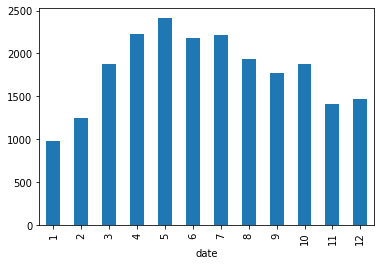

In [14]:
df.groupby(df["date"].dt.month)["id"].count().plot(kind="bar")

V rámci mesiacov bolo najviac predajov v mesiaci máj, avšak tento mesiac sa ako jediný v dátach vyskytuje pre 2 roky

In [15]:
df.resample("M", on="date")["id"].count()

date
2014-05-31    1768
2014-06-30    2180
2014-07-31    2211
2014-08-31    1940
2014-09-30    1774
2014-10-31    1878
2014-11-30    1411
2014-12-31    1471
2015-01-31     978
2015-02-28    1250
2015-03-31    1875
2015-04-30    2231
2015-05-31     646
Freq: M, Name: id, dtype: int64

Za najproduktívnejšie obdobie môžeme označiť júl 2014 a apríl 2015

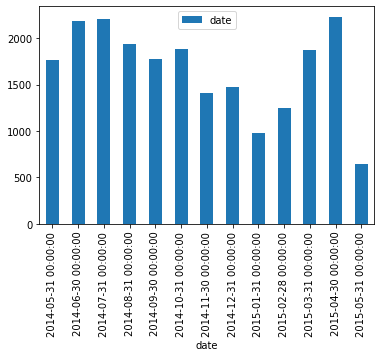

In [16]:
pd.DataFrame(df.resample("M", on="date")["date"].count()).plot(kind="bar")

In [17]:
df[df.groupby(["date"])["id"].transform("size") > 1]["date"].nunique()

358

In [18]:
min_date = min(df["date"])
max_date = max(df["date"])
print(f"Minimalny datum {min_date}, maximalny datum {max_date}")
print(max_date-min_date)

Minimalny datum 2014-05-02 00:00:00, maximalny datum 2015-05-27 00:00:00
390 days 00:00:00


V stĺpci `date` máme rozdiel 390 dní, pričom unikátnych dní bolo 358, z čoho nám vyplýva, že nie každý deň bol uskutočnený predaj nehnuteľnosti.

#### Stĺpec price

In [19]:
df["price"].value_counts()

450000.00000     172
350000.00000     172
550000.00000     159
500000.00000     152
425000.00000     150
325000.00000     148
400000.00000     145
375000.00000     138
300000.00000     133
525000.00000     131
250000.00000     130
475000.00000     120
330000.00000     119
650000.00000     117
275000.00000     113
315000.00000     111
415000.00000     111
280000.00000     110
600000.00000     110
390000.00000     110
440000.00000     109
320000.00000     108
435000.00000     105
340000.00000     103
310000.00000     101
335000.00000      98
420000.00000      97
360000.00000      96
260000.00000      95
265000.00000      95
575000.00000      93
380000.00000      93
625000.00000      93
305000.00000      92
430000.00000      91
345000.00000      91
530000.00000      91
270000.00000      90
700000.00000      89
465000.00000      89
245000.00000      89
370000.00000      88
490000.00000      88
290000.00000      88
750000.00000      87
355000.00000      87
385000.00000      86
410000.00000 

In [20]:
print("Priemer: %.2f" %df["price"].mean())
print("Median: %.2f" %df["price"].median())
print("Modus: %.2f, %.2f" %(df["price"].mode()[0], df["price"].mode()[1]))
print("Smerodajna odchylka: %.2f" %df["price"].std())

Priemer: 540088.14
Median: 450000.00
Modus: 350000.00, 450000.00
Smerodajna odchylka: 367127.20


In [21]:
buckets = pd.cut(df["price"], bins=10, include_lowest=True)
df.groupby(buckets)["id"].count()

price
(67374.999, 837500.0]     19022
(837500.0, 1600000.0]      2165
(1600000.0, 2362500.0]      298
(2362500.0, 3125000.0]       90
(3125000.0, 3887500.0]       26
(3887500.0, 4650000.0]        4
(4650000.0, 5412500.0]        4
(5412500.0, 6175000.0]        1
(6175000.0, 6937500.0]        1
(6937500.0, 7700000.0]        2
Name: id, dtype: int64

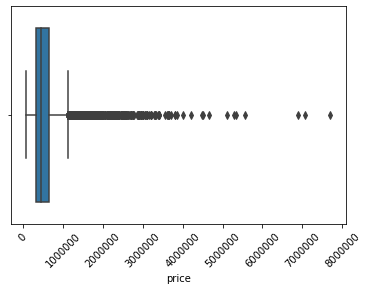

In [22]:
analysis.display_boxplot(df["price"])

In [114]:
whisker_l, whisker_r = analysis.get_whiskers(df["price"])
outl = sum(df["price"] < whisker_l),sum(df["price"] > whisker_r)
print(f"Pocet outlierov zlava: {outl[0]}")
print(f"Pocet outlierov zprava: {outl[1]}")

Pocet outlierov zlava: 0
Pocet outlierov zprava: 1146


Pri prvotnom pohľade na boxplot pre stĺpec `price` sa nám môže zdať, že sa tu vyskytuje veľké množstvo outlierov. Pozrieme sa však na rozdelenie hodnôt pomocou grafu početnosti

Skewness (asymetria): 4.024
Kurtosis (špicatosť): 37.577


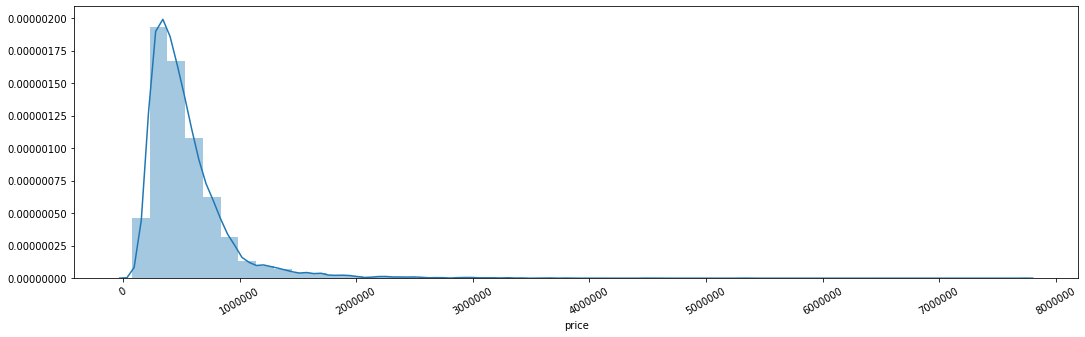

In [23]:
fig, ax = plt.subplots()
fig.set_size_inches(18, 5)

plt.xticks(rotation=30)
print("Skewness (asymetria): %.3f" %stats.skew(df["price"]))
print("Kurtosis (špicatosť): %.3f" %stats.kurtosis(df["price"],fisher=False))
ax = sns.distplot(df["price"], bins=50)

Stĺpec `price` je dôležitý, pretože v ďalších fázach projektu by sme hodnoty tohoto stĺpca chceli predikovať.
Ide o cenu, za ktorú bola nehnuteľnosť predaná. Z grafu je možné vidieť, že hodnoty cien sú veľmi naklonené doľava, čo dokazuje aj hodnota koeficientu asymetrie. Hodnota koeficientu špicatosti nám zas dodáva množstvo hodnôt sústredených na okrajoch rozdelenia, čo je v našom prípade veľmi vysoké (pre normálne rozdelenie ide o hodnotu 3).

Vzhľadom na tvrdenie o outlieroch podľa vyššie zobrazeného boxplotu a tvar rozdelenia musíme konštatovať, že na bližšie zistenie outlierov budeme potrebovať transformovať dáta, aby boli viac symetrické čo nám pomôže uvidieť outlierov pomocou boxplotu (zobrazenie outlierov v boxplote je vhodné pre symetricky rozdelené dáta)

Pre účel identifikácie outlierov použijeme teda box-cox transformáciu.

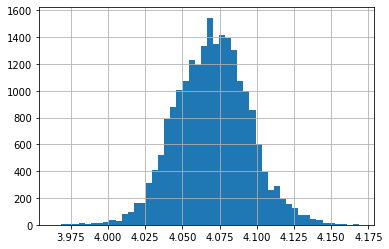

In [24]:
normalised, _ = stats.boxcox(df["price"])
pd.Series(normalised).hist(bins=50)

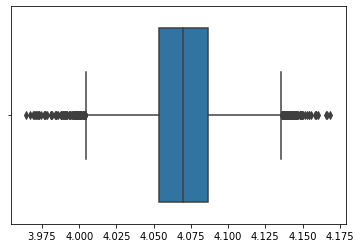

In [25]:
sns.boxplot(normalised)

Ako je možné vidieť, outlierov máme stále na jednej strane, avšak identifikovali sme outlierov aj na druhej strane

In [116]:
whisker_l, whisker_r = analysis.get_whiskers(pd.Series(normalised))
outl = sum(normalised < whisker_l),sum(normalised> whisker_r)
print(f"Pocet outlierov zlava: {outl[0]}")
print(f"Pocet outlierov zprava: {outl[1]}")

Pocet outlierov zlava: 121
Pocet outlierov zprava: 115


#### Stĺpec bedrooms

Tento stĺpec označuje počet spální v nehnuteľnosti.

In [26]:
df['bedrooms'].value_counts()

3     9824
4     6882
2     2760
5     1601
6      272
1      199
7       38
8       13
0       13
9        6
10       3
11       1
33       1
Name: bedrooms, dtype: int64

Ako je možné vidieť, hodnoty stĺpca `bedrooms` sa pohybujú v rozmedzí 1 až 33, najpočetnejšie zastúpenie majú budovy s tromi spálňami. 

In [27]:
df[df['bedrooms']>9]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
8757,1773100755,2014-08-21,520000.00000,11,3.00000,3000,4960,2.00000,0,0,3,7,2400,600,1918,1999,98106,47.55600,-122.36300,1420,4960
13314,627300145,2014-08-14,1148000.00000,10,5.25000,4590,10920,1.00000,0,2,3,9,2500,2090,2008,0,98004,47.58610,-122.11300,2730,10400
15161,5566100170,2014-10-29,650000.00000,10,2.00000,3610,11914,2.00000,0,0,4,7,3010,600,1958,0,98006,47.57050,-122.17500,2040,11914
15870,2402100895,2014-06-25,640000.00000,33,1.75000,1620,6000,1.00000,0,0,5,7,1040,580,1947,0,98103,47.68780,-122.33100,1330,4700
19254,8812401450,2014-12-29,660000.00000,10,3.00000,2920,3745,2.00000,0,0,4,7,1860,1060,1913,0,98105,47.66350,-122.32000,1810,3745


In [28]:
df[(df['bedrooms']>0)].groupby("bedrooms").agg({"sqft_living":["mean", "count"]})

sqft_living      
                mean count
bedrooms                  
1          884.61307   199
2         1239.75290  2760
3         1805.83724  9824
4         2554.64967  6882
5         3047.54528  1601
6         3284.34191   272
7         3974.21053    38
8         3800.00000    13
9         3775.00000     6
10        3706.66667     3
11        3000.00000     1
33        1620.00000     1

Hodnota 33 pri počte spální je netriviálna vzhľadom na priemernú rozlohu obytného priestoru skupín ostatných nehnuteľností. Podľa prepočtu by v tomto dome vychádzalo na jednu spálňu miesto s rozlohou 4.56 m<sup>2</sup> a to by na ostatné miestnosti v dome nezostalo miesto. Túto hodnotu teda považujeme za chybu merania a vo fáze predspracovania jú následne upravíme, s najväčšou pravdepodobnosťou pôjde o hodnotu 3.

#### Stĺpec bathrooms

In [29]:
df["bathrooms"].value_counts()

2.50000    5380
1.00000    3852
1.75000    3048
2.25000    2047
2.00000    1930
1.50000    1446
2.75000    1185
3.00000     753
3.50000     731
3.25000     589
3.75000     155
4.00000     136
4.50000     100
4.25000      79
0.75000      72
4.75000      23
5.00000      21
5.25000      13
0.00000      10
5.50000      10
1.25000       9
6.00000       6
0.50000       4
5.75000       4
8.00000       2
6.25000       2
6.50000       2
6.75000       2
7.50000       1
7.75000       1
Name: bathrooms, dtype: int64

In [30]:
df['bathrooms'][df['bathrooms'] % 1 == 0].count()

6710

In [31]:
df['bathrooms'][df['bathrooms'] % 1 != 0].count()

14903

Stĺpec `bathrooms` obsahuje aj desatinné čísla, pretože za plnohodnotnú kúpelňu sa považuje iba taká, ktorá obsahuje umývadlo, sprchový kút, vaňu a záchod. Ak kúpelňa neobsahuje niektorú z týchto položiek, je hodnota v tomto stĺpci znížená o 0,25 pre každý chýbajúci prvok vodoinštalácie.

Okrem toho pozorujeme aj výskyt domov, kde akékoľvek kúpeľňové vybavenie chýba a teda máme 10 domov prípadov, kde sa nachádza hodnota 0.0

In [32]:
print(f"Pocet domov bez kupelnoveho vybavenia: {df[df['bathrooms']==0.0]['id'].nunique()}")

Pocet domov bez kupelnoveho vybavenia: 10


In [33]:
df[df['bathrooms']==0.0]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
875,6306400140,2014-06-12,1095000.00000,0,0.00000,3064,4764,3.50000,0,2,3,7,3064,0,1990,0,98102,47.63620,-122.32200,2360,4000
1149,3421079032,2015-02-17,75000.00000,1,0.00000,670,43377,1.00000,0,0,3,3,670,0,1966,0,98022,47.26380,-121.90600,1160,42882
3119,3918400017,2015-02-05,380000.00000,0,0.00000,1470,979,3.00000,0,2,3,8,1470,0,2006,0,98133,47.71450,-122.35600,1470,1399
5832,5702500050,2014-11-04,280000.00000,1,0.00000,600,24501,1.00000,0,0,2,3,600,0,1950,0,98045,47.53160,-121.74900,990,22549
6994,2954400190,2014-06-24,1295650.00000,0,0.00000,4810,28008,2.00000,0,0,3,12,4810,0,1990,0,98053,47.66420,-122.06900,4740,35061
9773,3374500520,2015-04-29,355000.00000,0,0.00000,2460,8049,2.00000,0,0,3,8,2460,0,1990,0,98031,47.40950,-122.16800,2520,8050
9854,7849202190,2014-12-23,235000.00000,0,0.00000,1470,4800,2.00000,0,0,3,7,1470,0,1996,0,98065,47.52650,-121.82800,1060,7200
10481,203100435,2014-09-18,484000.00000,1,0.00000,690,23244,1.00000,0,0,4,7,690,0,1948,0,98053,47.64290,-121.95500,1690,19290
14423,9543000205,2015-04-13,139950.00000,0,0.00000,844,4269,1.00000,0,0,4,7,844,0,1913,0,98001,47.27810,-122.25000,1380,9600
19452,3980300371,2014-09-26,142000.00000,0,0.00000,290,20875,1.00000,0,0,1,1,290,0,1963,0,98024,47.53080,-121.88800,1620,22850


Väčšina z budov, ktoré nemajú žiadne kúpeľňové vybavenie, nemajú ani spálne, okrem toho sa hodnotenia technického stavu (stĺpec `condition`) pohybuje v nižších hodnotách, čo môže vypovedať o zhoršenom technickom stave

#### Stĺpec sqft_living

In [34]:
df["sqft_living"].value_counts()

1300     138
1400     135
1440     133
1010     129
1660     129
1800     129
1820     128
1480     125
1720     125
1540     124
1560     124
1320     122
1250     120
1580     119
1370     118
1200     118
1900     117
1780     117
1650     117
2100     116
1460     116
1680     116
1430     116
1740     115
1830     114
1510     114
1340     113
1260     113
1500     112
1640     112
1240     112
1470     112
1610     112
2120     111
1790     110
1690     110
1960     110
1600     109
1670     109
1530     109
1410     109
1700     108
1980     105
1590     104
2020     104
2040     104
1760     104
2000     103
1270     102
1520     102
1940     101
2240     101
1840     101
1280     100
1140     100
2060     100
1730     100
1850     100
1570     100
1620      99
1490      99
2080      98
1890      98
1770      98
1150      98
1810      98
1550      96
1360      96
2160      96
1870      96
2090      95
1350      95
1060      94
2130      94
1920      94
1630      94
2200      93

In [35]:
df["sqft_living"].describe()

count   21613.00000
mean     2079.89974
std       918.44090
min       290.00000
25%      1427.00000
50%      1910.00000
75%      2550.00000
max     13540.00000
Name: sqft_living, dtype: float64

Stĺpec `sqft_living` udáva rozlohu obytnej časti nehnuteľnosti v štvorcových stopách, pričom 1 meter štvorcový = 10.7639104 sq ft

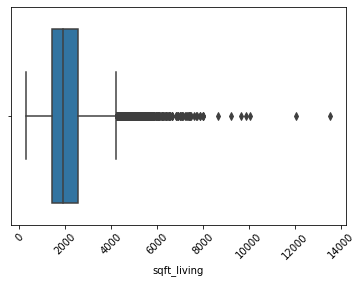

In [36]:
analysis.display_boxplot(df["sqft_living"])

In [127]:
whisker_l, whisker_r = analysis.get_whiskers(df["sqft_living"])
outl = sum(df["sqft_living"] < whisker_l),sum(df["sqft_living"] > whisker_r)
print(f"Pocet outlierov zlava: {outl[0]}")
print(f"Pocet outlierov zprava: {outl[1]}")

Pocet outlierov zlava: 0
Pocet outlierov zprava: 572


Skewness (asymetria): 1.471


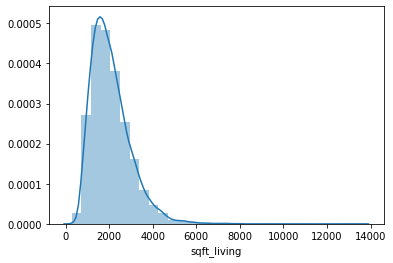

In [37]:
sns.distplot(df["sqft_living"], bins=30)
print("Skewness (asymetria): %.3f" %stats.skew(df["sqft_living"]))

Opäť môžeme z pôvodných dát pozorovať množstvo outlierov na jednej strane boxplotu, koeficient asymetrie nám ale napovedá o nesymetrickom rozdelení hodnôt. Opäť teda skúsime normalizovať dáta v tomto stĺpci, tentoraz pomocou logaritmu

Skewness (asymetria): -0.035


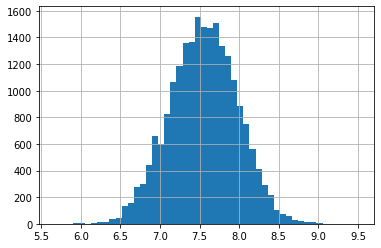

In [38]:
normalised_liv = np.log(df["sqft_living"])
pd.Series(normalised_liv).hist(bins=50)
print("Skewness (asymetria): %.3f" %stats.skew(normalised_liv))

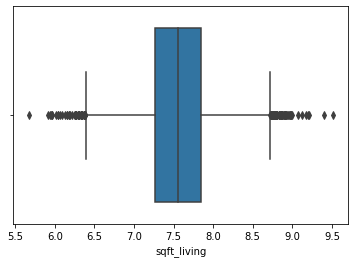

In [39]:
sns.boxplot(normalised_liv)

Opäť sme objavili aj na outlierov na druhej strane, čo môže byť následkom vychýlenosti pôvodného rozdelenia hodnôt doľava, takže outlierov na tejto strane nebolo možné boxplotom rozpoznať. Zároveň je sa počet outlierov oproti pôvodnému počtu znížil asi na pätinu

In [43]:
whisker_l, whisker_r = analysis.get_whiskers(normalised_liv)
outl = sum(normalised_liv < whisker_l),sum(normalised_liv > whisker_r)
print(f"Pocet outlierov zlava: {outl[0]}")
print(f"Pocet outlierov zprava: {outl[1]}")

Pocet outlierov zlava: 50
Pocet outlierov zprava: 60


#### Stĺpec sqft_lot	

In [44]:
df["sqft_lot"].value_counts()

5000       358
6000       290
4000       251
7200       220
4800       120
7500       119
4500       114
8400       111
9600       109
3600       103
9000        93
3000        84
5100        78
7000        76
8000        76
5500        73
8100        72
7800        69
4080        67
7700        66
7350        64
5200        64
5750        61
4400        56
5400        54
6600        52
6250        50
4200        49
7560        48
10000       46
10800       44
9750        43
12000       42
8800        42
6500        40
6120        39
7210        38
2500        36
8250        34
4600        34
5250        32
6300        32
6380        31
3200        31
10500       31
7620        30
10200       30
5700        30
9900        29
5040        29
3800        28
15000       28
4750        27
5600        27
7680        27
5120        27
6750        26
7920        25
10125       25
3750        24
11250       24
3060        24
5650        23
6400        23
7650        23
3400        22
6200      

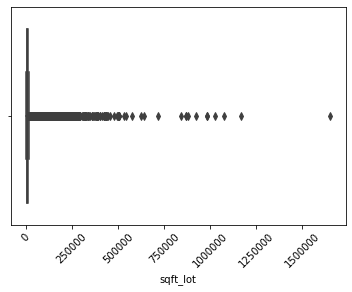

In [45]:
analysis.display_boxplot(df["sqft_lot"])

Tento stĺpec má už na prvý pohľad veľmi vysoký rozptyl hodnôt.

In [128]:
whisker_l, whisker_r = analysis.get_whiskers(pd.Series(df["sqft_lot"]))
outl = sum(df["sqft_lot"] < whisker_l),sum(df["sqft_lot"] > whisker_r)
print(f"Pocet outlierov zlava: {outl[0]}")
print(f"Pocet outlierov zprava: {outl[1]}")

Pocet outlierov zlava: 0
Pocet outlierov zprava: 2425


In [46]:
df["sqft_lot"].describe()

count     21613.00000
mean      15106.96757
std       41420.51152
min         520.00000
25%        5040.00000
50%        7618.00000
75%       10688.00000
max     1651359.00000
Name: sqft_lot, dtype: float64

Skewness (asymetria): 13.059


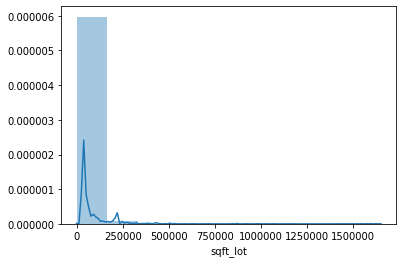

In [47]:
sns.distplot(df["sqft_lot"], bins = 10)
print("Skewness (asymetria): %.3f" %stats.skew(df["sqft_lot"]))

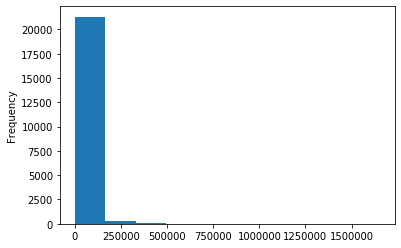

In [48]:
df["sqft_lot"].plot(kind='hist')

Skewness (asymetria): -0.107


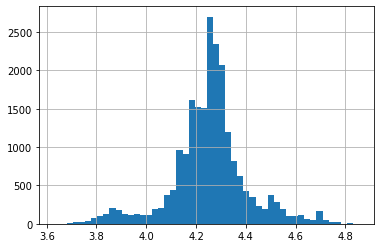

In [130]:
normalised_lot,_ = stats.boxcox(df["sqft_lot"])
# normalised_lot = np.sqrt(df["sqft_lot"])
pd.Series(normalised_lot).hist(bins=50)
print("Skewness (asymetria): %.3f" %stats.skew(normalised_lot))

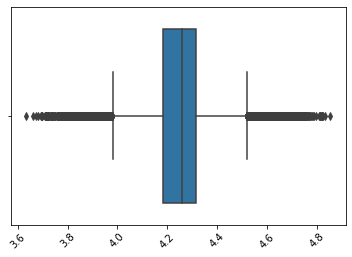

In [50]:
ax = sns.boxplot(normalised_lot)
plt.setp(ax.get_xticklabels(), rotation=45)
plt.show()

In [97]:
whisker_l, whisker_r = analysis.get_whiskers(pd.Series(normalised_lot))
outl = sum(normalised_lot < whisker_l),sum(normalised_lot > whisker_r)
print(f"Pocet outlierov zlava: {outl[0]}")
print(f"Pocet outlierov zprava: {outl[1]}")

Pocet outlierov zlava: 1163
Pocet outlierov zprava: 1112


Na detekciu outlierov sme opäť použili boxcox normalizáciu a tá opäť ukázala, že outlierov máme na oboch koncov fúzov

#### Stĺpec floors

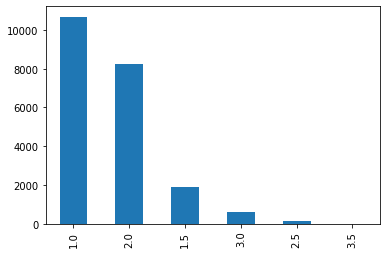

In [51]:
df["floors"].value_counts().plot(kind='bar')

Stĺpec `floors` vyjadruje počet poschodí. Nachádzajú sa tu však aj hodnoty s granularitou 0.5, čo znamená, že sa môže jednať o *Floor Area Ratio (FAR)*, ktoré je vyjadrené ako podiel celkovej plochy poschodia a veľkosti plochy pozemku, na ktorom je budova s poschodím postavená. (zdroj: https://en.wikipedia.org/wiki/Floor_area_ratio#/media/File:FAR_vs_BCR.svg)
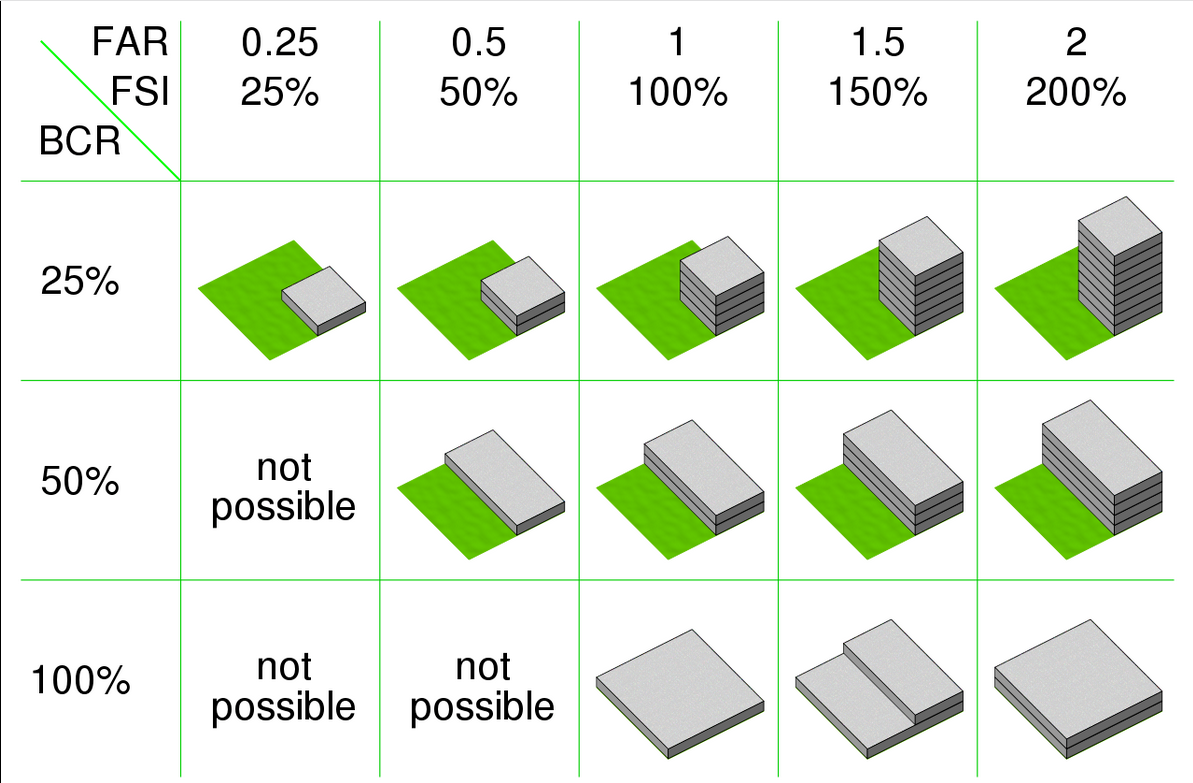

#### Stĺpec waterfront

In [52]:
df["waterfront"].value_counts()

0    21450
1      163
Name: waterfront, dtype: int64

Stĺpec `waterfront` je binárnou reprezentáciou toho, či z nehnuteľnosti je výhľad na pobrežie.

#### Stĺpec view

In [53]:
df["view"].value_counts()

0    19489
2      963
3      510
1      332
4      319
Name: view, dtype: int64

In [54]:
df['view'][df['view'] > 0].count()

2124

Stĺpec `view` vyjadruje kvalitu výhľadu z nehnuteľnosti, pričom 4 je najlepší výhľad a 0 naopak najhorší.

Len 2124 nehnuteľností má označenie adekvátneho výhľadu.

#### Stĺpec condition

In [55]:
df["condition"].value_counts()

3    14031
4     5679
5     1701
2      172
1       30
Name: condition, dtype: int64

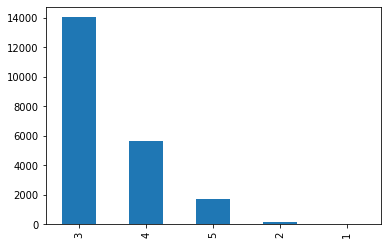

In [56]:
df["condition"].value_counts().plot(kind='bar')

Stĺpec `condition` vyjadruje stav, v akom sa nehnuteľnosť nachádza, 5 reprezentuje výborný stav, budovy označené číslom 1 nosia smutnú nálepku zlého technického stavu.

#### Stĺpec grade

In [57]:
df["grade"].value_counts()

7     8981
8     6068
9     2615
6     2038
10    1134
11     399
5      242
12      90
4       29
13      13
3        3
1        1
Name: grade, dtype: int64

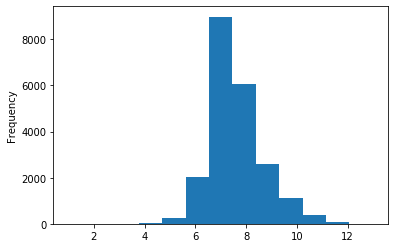

In [58]:
df["grade"].plot.hist(bins=13)

Stĺpec `grade` reprezentuje úroveň kvality budovy, pričom v sebe kombinuje hodnotenie konštrukčného návrhu a dizajnu nábytku a dekoru. Je vyjadrený hodnotami od 1 do 13.

#### Stĺpec sqft_above

In [59]:
df["sqft_above"].value_counts()

1300    212
1010    210
1200    206
1220    192
1140    184
1400    180
1060    178
1180    177
1340    176
1250    174
1320    172
1100    164
1080    161
1040    160
1240    160
1150    159
1330    158
1440    155
1260    155
1120    154
1270    153
1370    153
1280    151
1090    148
1210    147
1390    147
1290    146
1540    145
960     144
1430    143
1160    143
1460    141
1000    138
1230    137
1170    137
1600    136
1410    136
1350    135
1360    134
1470    133
1480    130
1510    129
1420    127
1560    127
1050    126
1500    125
1520    125
1610    124
1130    124
1020    123
1450    119
1650    118
1070    116
1030    115
1680    115
980     114
1380    114
940     114
860     113
1190    111
1690    110
1550    110
1310    109
1720    109
1640    107
1660    106
1580    106
1590    105
1670    105
1490    105
880     104
1620    103
1570    102
1530    102
1800    100
1110     99
900      97
1770     97
1780     97
1700     97
910      97
1730     96
840      96
1630

In [60]:
df["sqft_above"].describe()

count   21613.00000
mean     1788.39069
std       828.09098
min       290.00000
25%      1190.00000
50%      1560.00000
75%      2210.00000
max      9410.00000
Name: sqft_above, dtype: float64

Skewness (asymetria): 1.447


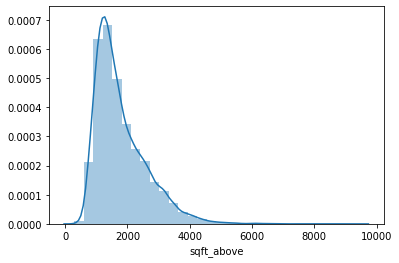

In [102]:
sns.distplot(df["sqft_above"], bins=30)
print("Skewness (asymetria): %.3f" %stats.skew(df["sqft_above"]))

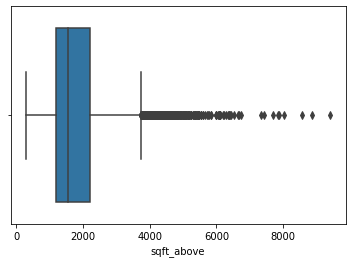

In [62]:
sns.boxplot(df["sqft_above"])

Stĺpec `sqft_above` vyjadruje obytnú plochu nehnuteľnosti, ktorá sa nachádza v nadzemnej časti budovy.

In [131]:
whisker_l, whisker_r = analysis.get_whiskers(pd.Series(df["sqft_above"]))
outl = sum(df["sqft_above"] < whisker_l),sum(df["sqft_above"] > whisker_r)
print(f"Pocet outlierov zlava: {outl[0]}")
print(f"Pocet outlierov zprava: {outl[1]}")

Pocet outlierov zlava: 0
Pocet outlierov zprava: 611


Skewness (asymetria): 0.012


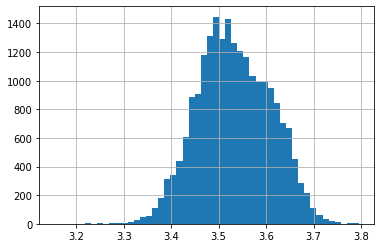

In [100]:
normalised_above,_ = stats.boxcox(df["sqft_above"])
pd.Series(normalised_above).hist(bins=50)
print("Skewness (asymetria): %.3f" %stats.skew(normalised_above))

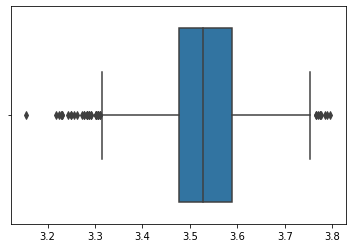

In [103]:
sns.boxplot(normalised_above)

In [101]:
whisker_l, whisker_r = analysis.get_whiskers(pd.Series(normalised_above))
outl = sum(normalised_above < whisker_l),sum(normalised_above > whisker_r)
print(f"Pocet outlierov zlava: {outl[0]}")
print(f"Pocet outlierov zprava: {outl[1]}")

Pocet outlierov zlava: 33
Pocet outlierov zprava: 9


#### Stĺpec sqft_basement

In [63]:
df["sqft_basement"].value_counts()

0       13126
600       221
700       218
500       214
800       206
400       184
1000      149
900       144
300       142
200       108
530       107
480       106
750       105
450       103
720       102
620        91
580        85
840        85
420        81
860        80
1100       80
670        79
780        77
380        76
850        76
550        76
650        76
680        75
240        74
360        73
940        72
290        72
770        71
910        71
350        70
1200       70
880        69
440        69
520        69
1010       68
920        68
630        68
760        66
740        66
730        65
960        65
560        64
430        64
640        63
950        63
280        63
460        63
340        63
790        63
570        62
820        62
830        59
1060       59
310        58
980        57
540        57
1040       57
140        56
810        56
470        55
250        55
120        54
990        54
890        53
660        52
1020       52
1070  

In [64]:
df["sqft_basement"].describe()

count   21613.00000
mean      291.50905
std       442.57504
min         0.00000
25%         0.00000
50%         0.00000
75%       560.00000
max      4820.00000
Name: sqft_basement, dtype: float64

Skewness (asymetria): 0.784


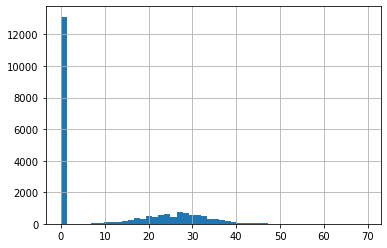

In [133]:
normalised_liv = np.sqrt(df["sqft_basement"])
pd.Series(normalised_liv).hist(bins=50)
print("Skewness (asymetria): %.3f" %stats.skew(normalised_liv))

In [65]:
df['sqft_basement'][df['sqft_basement'] > 0].count()

8487

Iba 8487 nehnuteľností má suterén.

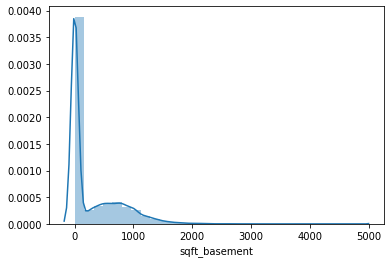

In [66]:
sns.distplot(df["sqft_basement"], bins=30)

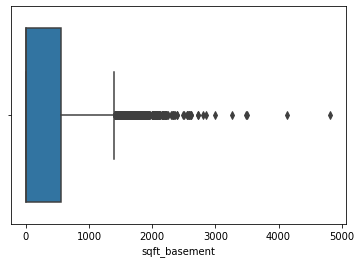

In [67]:
sns.boxplot(df["sqft_basement"])

Stĺpec `sqft_basement` vyjadruje rozlohu suterénu budovy. Pokiaľ budova suterénom nedisponuje, je táto hodnota nastavená na 0, čomu zodpovedá 13126 záznamov.

#### Stĺpec yr_built

In [68]:
df["yr_built"].value_counts()

2014    559
2006    454
2005    450
2004    433
2003    422
2007    417
1977    417
1978    387
1968    381
2008    367
1967    350
1979    343
1959    334
1990    320
1962    312
2001    305
1954    305
1987    294
1989    290
1969    280
1955    271
1988    270
1999    265
1947    263
1963    256
1976    253
1966    250
1950    250
1994    249
1960    248
1980    240
1998    239
1948    235
2009    230
1984    229
1951    229
1985    228
1961    224
1958    224
1991    224
1953    223
1942    223
2002    222
1952    220
2000    218
1986    215
1983    212
1993    202
2013    201
1981    199
1956    198
1957    198
1992    198
1996    195
1949    195
1975    189
1965    187
1926    180
1997    177
1964    172
2012    170
1943    170
1995    169
1925    165
1974    162
1941    161
1940    156
1972    149
1973    149
2010    143
1944    140
1924    139
1910    134
1970    132
2011    130
1928    126
1946    126
1918    120
1927    115
1929    114
1939    106
1982    105
1971    104
1920

In [69]:
df["yr_built"].min()

1900

In [70]:
df["yr_built"].max()

2015

In [71]:
df["yr_built"].mode()

0    2014
dtype: int64

In [72]:
df['yr_built'][df['yr_built'] > 2003].count()

3592

Stĺpec `yr_built` reprezentuje rok, v ktorom bola nehnuteľnosť postavená. Najčastejšou hodnotou (modus) je rok 2014, najviac sa teda predalo novostavieb. Budovy, ktorých vek je do 10 rokov tvoria 3592 predajov.  

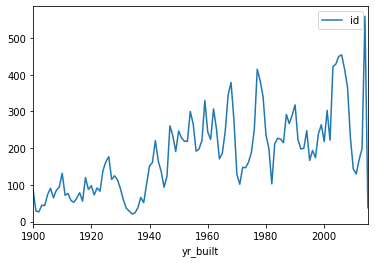

In [73]:
df_id_uniq = df.drop_duplicates(subset=["id"])
df_id_uniq.groupby(['yr_built']).agg({"id":"count"}).plot.line()
# fig, ax = plt.subplots(figsize=(15,8))
# sns.lineplot(x='yr_built', y='id', data=df_id_uniq, ax=ax)

Graf nám zobrazuje početnosť nehnuteľností pre jednotlivé roky, v ktorých boli postavené

#### Stĺpec yr_renovated

In [74]:
df["yr_renovated"].value_counts()

0       20699
2014       91
2013       37
2003       36
2000       35
2007       35
2005       35
2004       26
1990       25
2006       24
2009       22
1989       22
2002       22
1991       20
2001       19
1998       19
1994       19
1993       19
1987       18
1983       18
1984       18
2010       18
2008       18
1986       17
1985       17
1999       17
1992       17
2015       16
1995       16
1996       15
1997       15
1988       15
2011       13
1980       11
2012       11
1982       11
1979       10
1970        9
1968        8
1977        8
1975        6
1978        6
1981        5
1964        5
1965        5
1958        5
1973        5
1969        4
1972        4
1960        4
1963        4
1956        3
1945        3
1974        3
1953        3
1955        3
1976        3
1957        3
1962        2
1950        2
1967        2
1946        2
1971        2
1940        2
1954        1
1934        1
1959        1
1951        1
1948        1
1944        1
Name: yr_renovated, 

In [75]:
df['yr_renovated'][df['yr_renovated'] > 0].count()

914

Iba 914 budov prešlo rekonštrukciou.

In [76]:
df['yr_renovated'][(0 < df['yr_renovated']) & (df['yr_renovated'] < df['yr_built'])].count()

0

Stĺpec `yr_renovated` vyjadruje rok, kedy došlo k rekonštrukcii nehnuteľnosti. Pokiaľ ide o budovu v pôvodnom stave, stĺpec obsahuje hodnotu 0. Dataset bol skontrolovaný pre chybne zadané hodnoty (`yr_renovated` menší ako `yr_built`).

#### Stĺpec zipcode

In [126]:
df["zipcode"].value_counts()

98103    602
98038    590
98115    583
98052    574
98117    553
98042    548
98034    545
98118    508
98023    499
98006    498
98133    494
98059    468
98058    455
98155    446
98074    441
98033    432
98027    412
98125    410
98056    406
98053    405
98001    362
98075    359
98126    354
98092    351
98144    343
98106    335
98116    330
98029    321
98004    317
98199    317
98065    310
98122    290
98146    288
98028    283
98008    283
98040    282
98198    280
98003    280
98031    274
98072    273
98168    269
98112    269
98055    268
98107    266
98136    263
98178    262
98030    256
98177    255
98166    254
98022    234
98105    229
98045    221
98002    199
98077    198
98011    195
98019    190
98108    186
98119    184
98005    168
98007    141
98188    136
98032    125
98014    124
98070    118
98109    109
98102    105
98010    100
98024     81
98148     57
98039     50
Name: zipcode, dtype: int64

In [123]:
df["zipcode"].nunique()

70

Stĺpec `zipcode` zastupuje PSČ, v ktorom sa daná nehnuteľnosť nachádza. Celkovo v datasete identifikujeme 70 unikátnych PSČ.

#### Stĺpec lat

In [78]:
df["lat"].value_counts()

47.54910    17
47.68460    17
47.66240    17
47.53220    17
47.67110    16
47.68860    16
47.69550    16
47.68600    15
47.66470    15
47.69040    15
47.68420    15
47.54020    15
47.54000    14
47.63740    14
47.53960    14
47.68210    14
47.66510    14
47.68530    14
47.67270    14
47.65340    14
47.53230    14
47.54450    14
47.70760    14
47.55180    14
47.68440    14
47.55330    14
47.54270    14
47.53420    14
47.69140    14
47.67290    14
47.68570    13
47.69680    13
47.56590    13
47.63680    13
47.67540    13
47.53050    13
47.62850    13
47.68750    13
47.69710    13
47.68010    13
47.67650    13
47.69700    13
47.66840    13
47.72220    13
47.55030    13
47.69810    13
47.63880    13
47.69160    13
47.51500    12
47.77350    12
47.69880    12
47.69480    12
47.54890    12
47.65360    12
47.68490    12
47.53280    12
47.55150    12
47.55400    12
47.63800    12
47.56310    12
47.68930    12
47.54010    12
47.62320    12
47.67190    12
47.70270    12
47.69110    12
47.51680  

In [120]:
df["lat"].min(), df["lat"].max()

(47.1559, 47.7776)

Stĺpec `lat` vyjadruje zemepisnú šírku ako prvú časť súradnicového systému. Reprezentuje uhlovú vzdialenosť lokalizovaného bodu od rovníka. 

#### Stĺpec long

In [81]:
df["long"].value_counts()

-122.29000    116
-122.30000    111
-122.36200    104
-122.29100    100
-122.37200     99
-122.36300     99
-122.28800     98
-122.35700     96
-122.28400     95
-122.36500     94
-122.17200     94
-122.30600     93
-122.34600     93
-122.37500     92
-122.29900     92
-122.35100     92
-122.34800     92
-122.30400     92
-122.29500     91
-122.28500     90
-122.35000     90
-122.29200     90
-122.35200     89
-122.28900     89
-122.29800     88
-122.35900     88
-122.38400     87
-122.30100     86
-122.31700     86
-122.31600     86
-122.28700     85
-122.35400     85
-122.35300     85
-122.39100     85
-122.36100     85
-122.31100     84
-122.38500     84
-122.37100     83
-122.18900     83
-122.28600     83
-122.37800     81
-122.34900     81
-122.37000     81
-122.38800     81
-122.34000     80
-122.38700     79
-122.35800     78
-122.30700     78
-122.33100     78
-122.30800     78
-122.35600     77
-122.33700     77
-122.29700     76
-122.36000     76
-122.17400     75
-122.36900

In [121]:
df["long"].min(), df["long"].max()

(-122.51899999999999, -121.315)

Stĺpec `long` vyjadruje zemepisnú dĺžku ako druhú časť súradnicového systému. Reprezentuje uhlovú vzdialenosť medzi hlavným poludníkom a poludníkom prechádzajúcim lokalizovaným bodom.

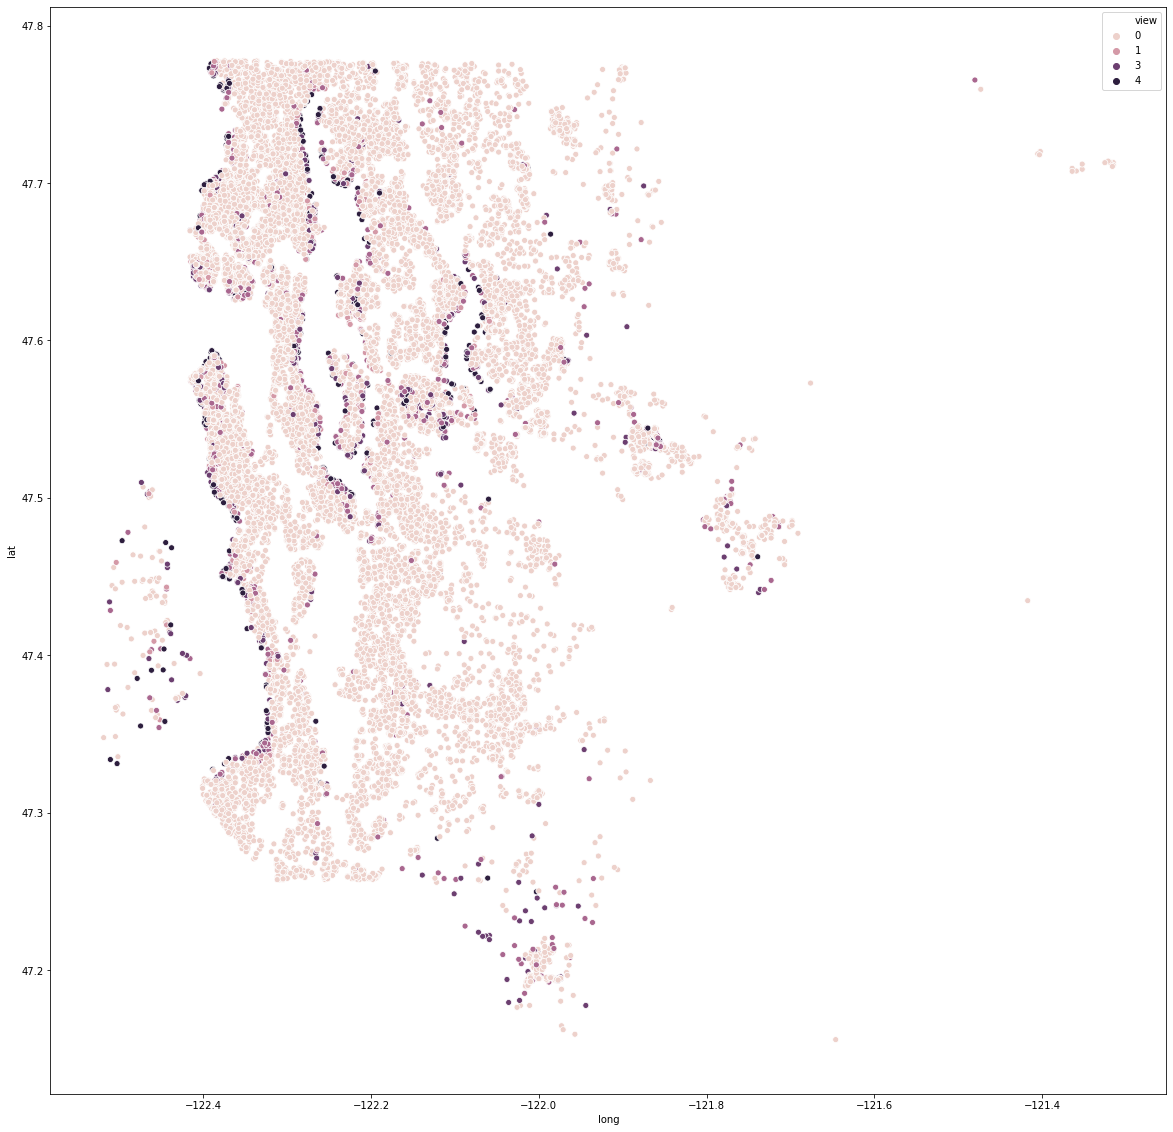

In [83]:
fig, ax = plt.subplots(figsize=(20,20))
sns.scatterplot(x='long', y='lat', hue="view", data=df, ax=ax)

Mapa vytvorená vizualizáciou všetkých bodov zo stĺpcov `lat` a `long`. Farebné odlíšenie nám ukazuje oblasti s najlepším výhľadom

#### Stĺpec sqft_living15

In [104]:
df["sqft_living15"].value_counts()

Skewness (asymetria): 1.108


1540    197
1440    195
1560    192
1500    181
1460    169
1580    167
1610    166
1800    166
1720    166
1620    165
1510    164
1760    163
1480    160
1410    159
1550    158
1670    157
1680    157
1820    157
1520    155
1660    155
1300    154
1780    154
1470    154
1570    154
1640    152
1600    149
1690    149
1700    148
1530    148
1320    148
1420    148
1590    143
1650    143
1490    142
1360    142
1310    139
1770    138
1940    137
1380    136
1950    135
1370    135
1830    135
1630    134
1850    134
1900    132
1880    132
1740    131
1400    131
1350    130
1390    129
1250    129
1450    127
1710    126
2090    126
2040    126
1430    126
1860    126
1750    123
1330    122
2060    121
1340    121
1280    120
1920    119
1810    119
1890    117
1970    117
1870    117
1960    115
2030    115
1910    115
1790    115
1980    114
2020    114
1840    114
2080    112
1730    112
1930    110
2000    109
1220    107
1260    106
1270    106
1230    106
1200    106
2010

Skewness (asymetria): 1.108


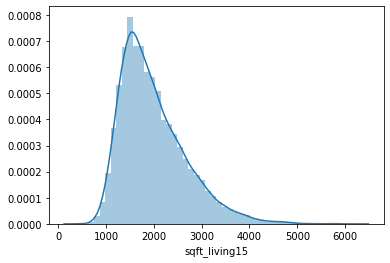

In [107]:
sns.distplot(df["sqft_living15"])
print("Skewness (asymetria): %.3f" %stats.skew(df["sqft_living15"]))

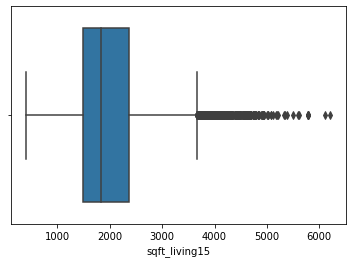

In [105]:
sns.boxplot(df["sqft_living15"])

Stĺpec je charakteristikou rozlohy obytného priestoru pre najbližších 15 susedných nehnuteľností, môžeme pozorovať veľký počet vychýlených hodnôt

#### Stĺpec sqft_lot15

In [86]:
df["sqft_lot15"].value_counts()

5000      427
4000      357
6000      289
7200      211
4800      145
7500      142
8400      116
3600      111
4500      111
5100      109
4080      106
8000      105
9600       99
8100       93
9000       92
7800       86
7700       85
5500       81
5400       71
6600       68
7350       67
5200       66
5750       64
4400       63
4200       61
10000      58
7560       57
5250       52
3000       52
9750       49
7620       47
7000       46
8800       46
10800      45
6250       44
7210       43
8250       42
10125      41
3800       41
6380       40
12000      39
7680       38
10500      37
5040       35
6300       34
11250      33
5700       33
7875       33
9800       32
7920       32
5800       31
3750       31
9450       31
6500       30
10200      30
9900       30
8500       29
7600       28
8750       28
7650       27
15000      27
6120       27
7440       26
9375       25
4750       25
4560       25
217800     25
9100       25
4590       24
3880       24
5120       23
8160  

Skewness (asymetria): 9.506


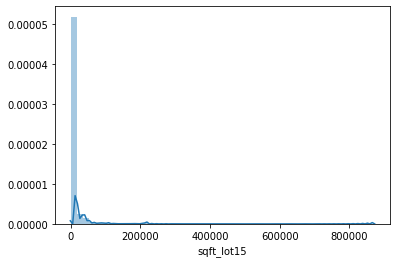

In [108]:
sns.distplot(df["sqft_lot15"])
print("Skewness (asymetria): %.3f" %stats.skew(df["sqft_lot15"]))

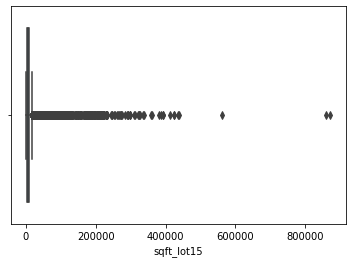

In [109]:
sns.boxplot(df["sqft_lot15"])

In [113]:
whisker_l, whisker_r = analysis.get_whiskers(df["sqft_lot15"])
outl = sum(df["sqft_lot15"] < whisker_l),sum(df["sqft_lot15"] > whisker_r)
print(f"Pocet outlierov zlava: {outl[0]}")
print(f"Pocet outlierov zprava: {outl[1]}")

Pocet outlierov zlava: 0
Pocet outlierov zprava: 2194


Podobne ako pri stĺpci `sqft_lot`, aj pri stĺpci popisujpcom rozlohu celého pozemku pre najbližších 15 susedných pozemkov pozorujeme pestrú škálu vychýlených hodnôt

Skewness (asymetria): -0.115


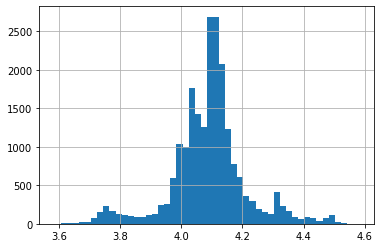

In [110]:
normalised_lot15,_ = stats.boxcox(df["sqft_lot15"])
pd.Series(normalised_lot15).hist(bins=50)
print("Skewness (asymetria): %.3f" %stats.skew(normalised_lot15))

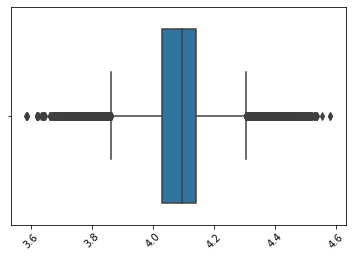

In [111]:
analysis.display_boxplot(normalised_lot15)

In [112]:
whisker_l, whisker_r = analysis.get_whiskers(pd.Series(normalised_lot15))
outl = sum(normalised_lot15 < whisker_l),sum(normalised_lot15 > whisker_r)
print(f"Pocet outlierov zlava: {outl[0]}")
print(f"Pocet outlierov zprava: {outl[1]}")

Pocet outlierov zlava: 1138
Pocet outlierov zprava: 1317


Pomocou boxcox transformácie sme aj pre stĺpec `sqft_lot15` určili outlierov z oboch strán boxplotu.

#### Pridaný stĺpec recon_age

Tento stĺpec sme sa rozhodli pridať kvôli skúmaniu dĺžky budovy od rekonštrukcie. Pokiaľ dom zrekonštruovaný nikdy nebol, bude platiť rozdiel medzi dnešným dňom a dňom postavenia, inak budeme robiť rozdiel dnešného roku a roku rekonštrukcie.

In [168]:
def calc_recon_age(yr_renovated, yr_built, yr_sold):
    if yr_renovated > 0:
        return yr_sold - yr_renovated
    else:
        return yr_sold - yr_built

df['recon_age'] = df[['yr_renovated', 'yr_built', 'date']].apply(lambda x: calc_recon_age(x['yr_renovated'], x['yr_built'], x['date'].year), axis=1)

In [167]:
df["recon_age"].value_counts()

 0      516
 9      498
 8      480
 11     466
 10     459
 7      428
 37     388
 36     383
 47     352
 6      340
 25     337
 46     337
 1      330
 38     324
 35     316
 27     316
 55     312
 13     309
 12     301
 24     291
 15     283
 52     282
 60     282
 26     281
 48     274
 16     273
 53     265
 14     255
 31     252
 23     251
 28     249
 20     247
 21     245
 29     241
 56     240
 45     236
 54     234
 64     232
 34     231
 66     230
 30     228
 59     228
 61     227
 5      226
 51     220
 67     218
 62     213
 18     211
 49     206
 22     205
 39     203
 17     200
 58     199
 57     199
 63     195
 2      190
 65     182
 19     181
 3      178
 40     176
 72     171
 73     166
 50     164
 68     163
 33     163
 42     160
 89     155
 74     148
 41     146
 71     145
 88     144
 32     143
 4      132
 90     131
 44     123
 75     116
 70     114
 87     112
 86     111
 69     103
 43     102
 85      99
 104     99
 105

Skewness (asymetria): 0.556


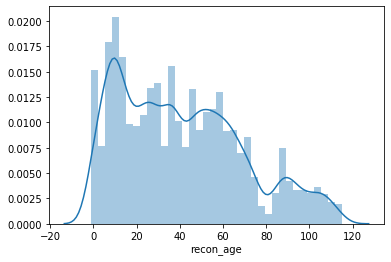

In [165]:
sns.distplot(df["recon_age"])
print("Skewness (asymetria): %.3f" %stats.skew(df["recon_age"]))

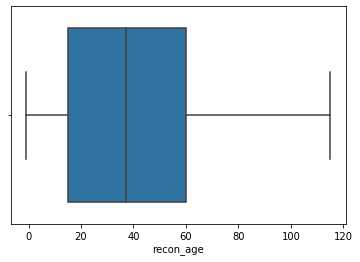

In [169]:
sns.boxplot(df["recon_age"])

### Párová analýza atribútov

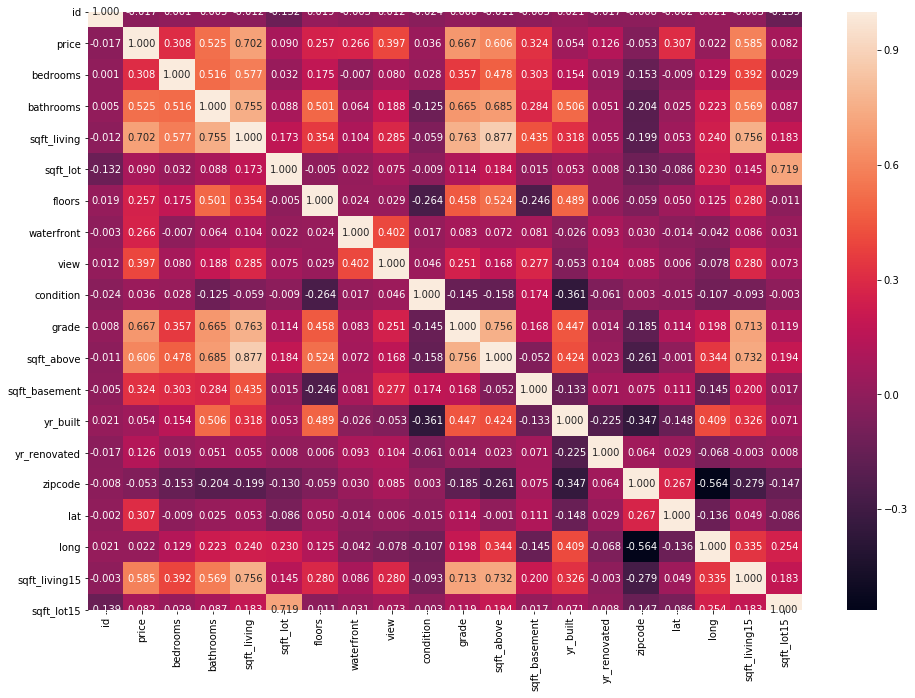

In [122]:
fig, ax = plt.subplots(figsize=(16,11))
sns.heatmap(df.corr(), ax=ax, annot=True, fmt=".3f")

Z teplotnej mapy vidíme korelácie medzi jednotlivými numerickými atribútmi, pričom je možné pozorovať viacero zaujímavých korelácii, napr. medzi atribútmi `grade` a `sqft_above`, `sqft_above` a `sqft_living` alebo `price` a `sqft_living`

#### Analýza dvojíc numerických atribútov

##### price a sqft_living

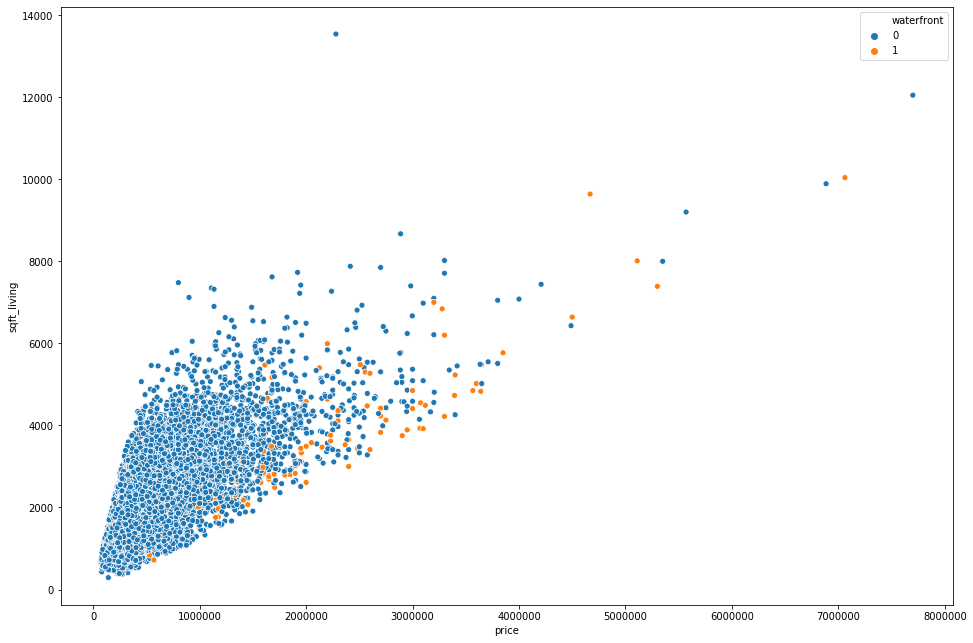

In [89]:
fig, ax = plt.subplots(figsize=(16,11))
sns.scatterplot(x="price", y="sqft_living", hue="waterfront", data=df, ax=ax)

In [90]:
df["price"].corr(df["sqft_living"])

0.7020350546118004

`price` a `sqft_living` majú silnú koreláciu

##### price a sqft_above 

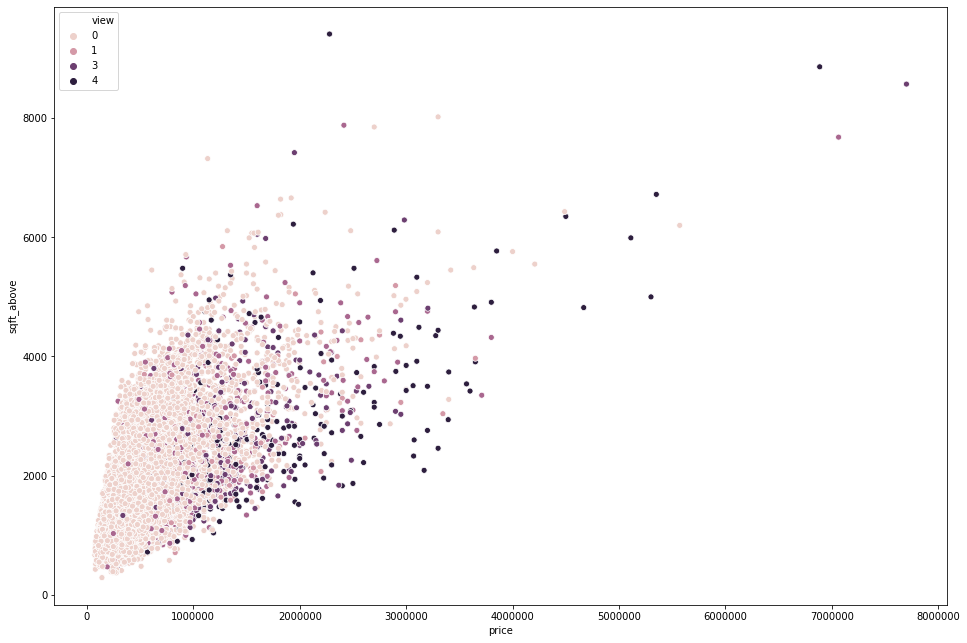

In [91]:
fig, ax = plt.subplots(figsize=(16,11))
sns.scatterplot(x="price", y="sqft_above", hue="view", data=df, ax=ax)

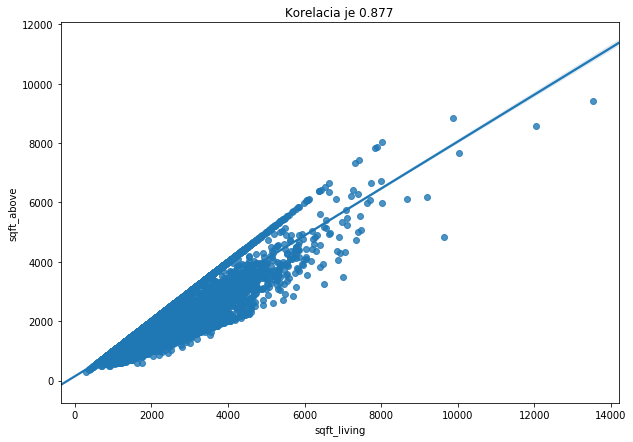

In [92]:
fig, ax = plt.subplots(figsize=(10,7))
corr = "Korelacia je %.3f" %df["sqft_above"].corr(df["sqft_living"])
ax.set_title(str(corr))
sns.regplot(x="sqft_living", y="sqft_above", data=df, ax=ax)
print()

Najsilnejšia korelácia je medzi atribútmi `sqft_above` a `sqft_living`, čo je logické vzhľadom na fakt, že obývaná plocha je zároveň aj plochou v nadzemnej časti nehnuteľnosti

#### Analýza kombinácií spojitého a kategorického atribútu

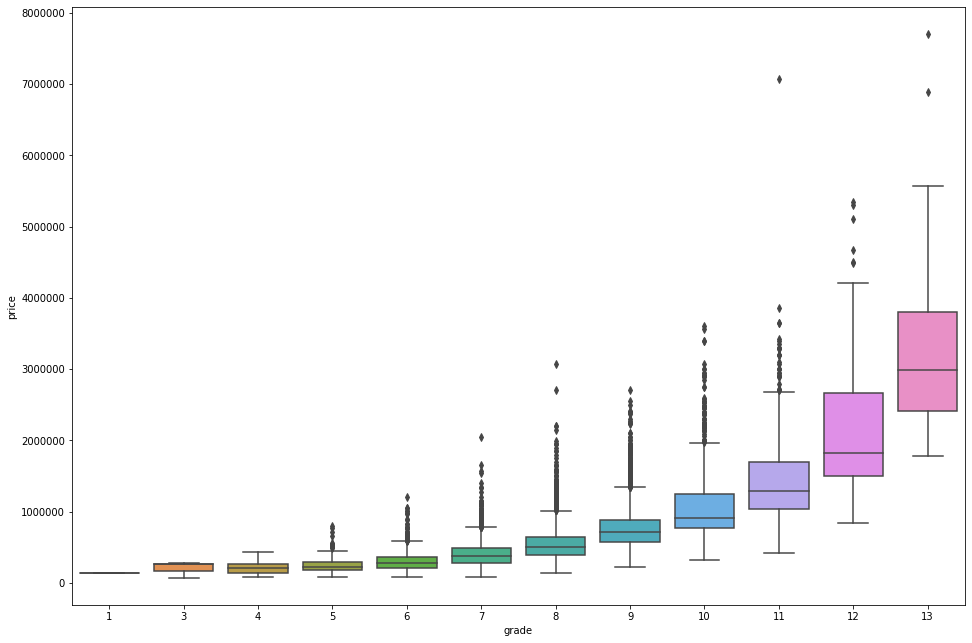

In [93]:
fig, ax = plt.subplots(figsize=(16,11))
sns.boxplot(x="grade", y="price", data=df, ax=ax)

In [94]:
df["price"].corr(df["grade"])

0.6674342560202366

#### Analýza dvojíc kategorických atribútov

### Opis chýbajúcich hodnôt

V datasete sme nezaznamenali žiadne chýbajúce hodnoty v žiadnom z atribútov.

### Opis vychýlených hodnôt

- **price** - transformácia pomocou boxcox transformácie a nahradenie outlierov 5-95 percentilom
- **bedrooms** - manuálna úprava inštancie s hodnotou 33 na 3
- **sqft_living** - transformácia pomocou logaritmu a nahradenie outlierov 5-95 percentilom
- **sqft_lot** - transformácia pomocou boxcox transformácie a nahradenie outlierov mediánom
- **sqft_above** - transformácia pomocou boxcox transformácie a nahradenie outlierov 5-95 percentilom
- **sqft_basement** - transformácia pomocou odmocniny a nahradenie outlierov priemerom alebo odstránenie stĺpca
- **sqft_living15** - transformácia pomocou logaritmu a nahradenie outlierov 5-95 percentilom
- **sqft_lot15** - transformácia pomocou boxcox transformácie a nahradenie outlierov mediánom

## Definovanie úlohy objavovania znalostí

Keďže chceme predikovať hodnotu spojitého numerického atribútu, identifikovali sme úlohu regresie. Pri riešení tejto úlohy by sme chceli vyskúšať viaceré algoritmy.

**1. Algoritmus c.1**

**2. Algoritmus c.2**

**3. Algoritmus c.3**

**TODO:** popisat algoritmy, ktorymi to chceme pravdepodobne riesit

## Predpokladaný scenár riešenia (problémy)

- vychýlené hodnoty - nahradiť 5-95 percentilom
- normalizácia hodnôt vybraných atribútov

- odvodene atributy (diff medzi rokom renovacie a datumom predaja)

- blizsie popisat scenar dalsieho postupu